In [1]:
# Compare different loss functions for a MINST classifier to visualize the effect of the loss function on the training process

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
# Preprocessing the MINST dataset
transform = transforms.ToTensor() # Convert the image to a tensor

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../../DATA
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../../../DATA
    Split: Test
    StandardTransform
Transform: ToTensor()


f:\Anaconda\envs\pytorchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


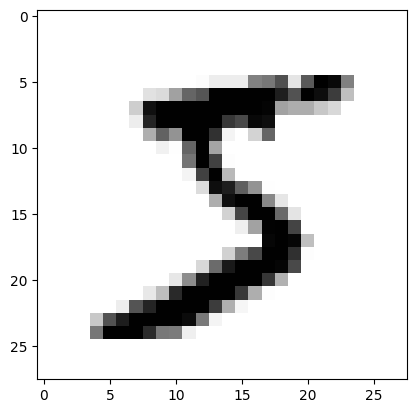

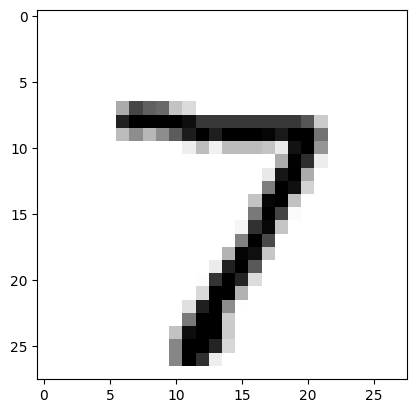

In [6]:
# Load the training and test datasets
train_data = datasets.MNIST(root='../../../../DATA', train=True, download=True, transform=transform)
print(train_data)
test_data = datasets.MNIST(root='../../../../DATA', train=False, download=True, transform=transform)
print(test_data)

# Check what the data looks like
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray_r")
plt.show()
plt.imshow(test_data[0][0].reshape((28,28)), cmap="gray_r")
plt.show()

In [7]:
# Batch loading with Data Loaders
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
print(len(train_loader))  # = Total datapoints[10000] / batch_size[500] = Total batches[20]

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)
print(len(test_loader)) # = Total datapoints[10000] / batch_size[500] = Total batches[20]

# flatten the image data
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

600
20
Batch shape: torch.Size([100, 1, 28, 28])


Labels:  [   7    1    6    9    5    0    7    1    1    9    5    7    0    2
    4]


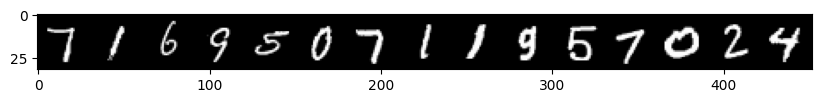

In [8]:
# View batch images - need more examination for better understanding
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:15].numpy())

# Print the first 15 images
im = make_grid(images[:15], nrow=15)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


In [42]:
# Create a Artifical Neural Network
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]): # The more neurons, the more parameters, the more computationally expensive
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    

torch.manual_seed(101)
model = MultilayerPerceptron()
model

# ANN --> CNN
params_list = []
for param in model.parameters():
    print(param.numel())
    params_list.append(param.numel())
print(f'Sum of parameters = {sum(params_list)}')

188160
240
20160
84
840
10
Sum of parameters = 209494


epoch:  0  batch:  600 [ 60000/60000]  loss: 0.13493605  \ accuracy:  90.405%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.10317269  \ accuracy:  96.078%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.07814392  \ accuracy:  97.340%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.03871480  \ accuracy:  98.015%
epoch:  4  batch:  600 [ 60000/60000]  loss: 0.06612967  \ accuracy:  98.437%
epoch:  5  batch:  600 [ 60000/60000]  loss: 0.08499409  \ accuracy:  98.865%
epoch:  6  batch:  600 [ 60000/60000]  loss: 0.02118083  \ accuracy:  99.133%
epoch:  7  batch:  600 [ 60000/60000]  loss: 0.01557583  \ accuracy:  99.257%
epoch:  8  batch:  600 [ 60000/60000]  loss: 0.01243826  \ accuracy:  99.385%
epoch:  9  batch:  600 [ 60000/60000]  loss: 0.06621440  \ accuracy:  99.508%

Duration: 28 seconds


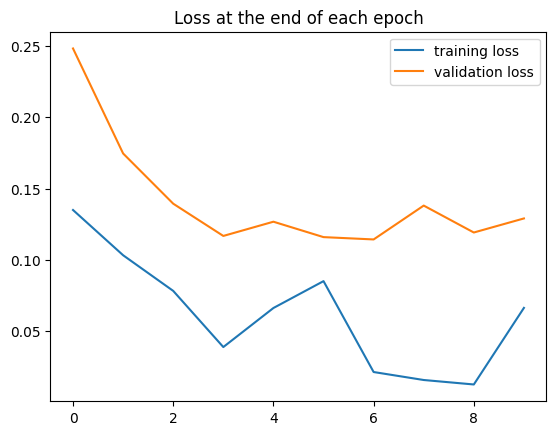

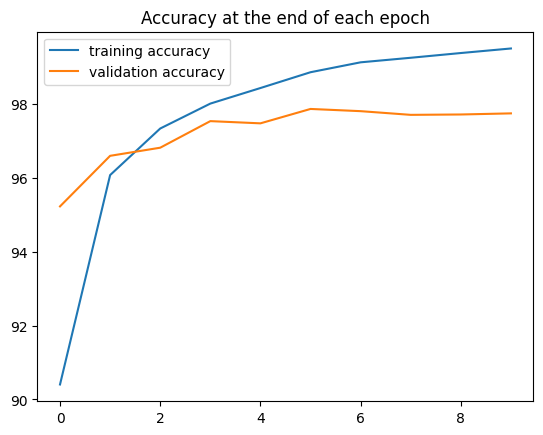

In [43]:
#Training the model
import time
start_time = time.time()
epochs = 10
# Define Loss Functions
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# Keep the same optimizer no matter the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \ accuracy: {trn_corr.item()*100/(100*b):7.3f}%')


# Update train loss & accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

plt.show()

plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.show()

In [44]:
# Evaluate test dataset as it went through training
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9523), tensor(9660), tensor(9682), tensor(9754), tensor(9748), tensor(9787), tensor(9781), tensor(9771), tensor(9772), tensor(9775)]

Test accuracy: 97.750%


In [45]:
# Evaluate all the ground truths and predictions
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9775/10000 =  97.750%


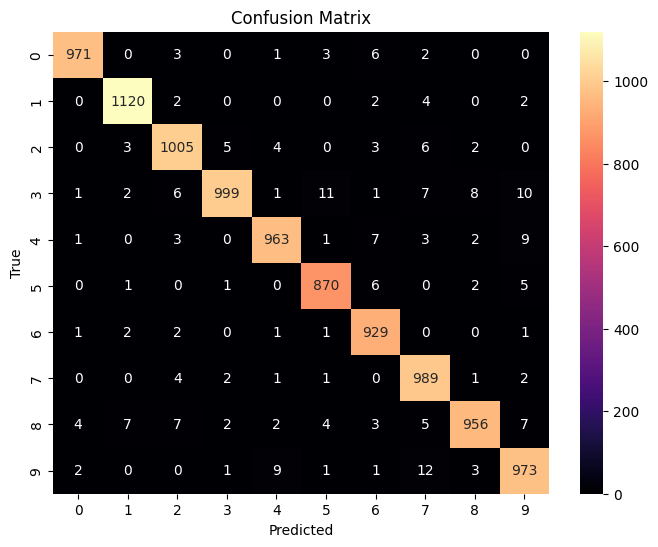

In [46]:
# Generate the confusion matrix
cm = confusion_matrix(predicted.view(-1), y_test.view(-1))
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()